In [40]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np


## Create a pipeline for data engineering

In [41]:
col_names = ["src_ip","dst_ip",
"src_port","dst_port","protocol",
"timestamp","flow_duration",
"flow_byts_s","flow_pkts_s",
"fwd_pkts_s","bwd_pkts_s",
"tot_fwd_pkts","tot_bwd_pkts",
"totlen_fwd_pkts","totlen_bwd_pkts",
"fwd_pkt_len_max","fwd_pkt_len_min",
"fwd_pkt_len_mean","fwd_pkt_len_std",
"bwd_pkt_len_max","bwd_pkt_len_min",
"bwd_pkt_len_mean","bwd_pkt_len_std",
"pkt_len_max","pkt_len_min",
"pkt_len_mean","pkt_len_std",
"pkt_len_var","fwd_header_len",
"bwd_header_len","fwd_seg_size_min",
"fwd_act_data_pkts","flow_iat_mean",
"flow_iat_max","flow_iat_min",
"flow_iat_std","fwd_iat_tot",
"fwd_iat_max","fwd_iat_min",
"fwd_iat_mean","fwd_iat_std",
"bwd_iat_tot","bwd_iat_max",
"bwd_iat_min","bwd_iat_mean",
"bwd_iat_std","fwd_psh_flags",
"bwd_psh_flags","fwd_urg_flags",
"bwd_urg_flags","fin_flag_cnt",
"syn_flag_cnt","rst_flag_cnt",
"psh_flag_cnt","ack_flag_cnt",
"urg_flag_cnt","ece_flag_cnt",
"down_up_ratio","pkt_size_avg",
"init_fwd_win_byts","init_bwd_win_byts",
"active_max","active_min",
"active_mean","active_std",
"idle_max","idle_min",
"idle_mean","idle_std",
"fwd_byts_b_avg","fwd_pkts_b_avg",
"bwd_byts_b_avg","bwd_pkts_b_avg",
"fwd_blk_rate_avg","bwd_blk_rate_avg",
"fwd_seg_size_avg","bwd_seg_size_avg",
"cwr_flag_count","subflow_fwd_pkts",
"subflow_bwd_pkts","subflow_fwd_byts",
"subflow_bwd_byts"]


feature_cols = ["protocol","flow_duration",
"flow_byts_s","flow_pkts_s",
"fwd_pkts_s","bwd_pkts_s",
"tot_fwd_pkts","tot_bwd_pkts",
"totlen_fwd_pkts","totlen_bwd_pkts",
"fwd_pkt_len_max","fwd_pkt_len_min",
"fwd_pkt_len_mean","fwd_pkt_len_std",
"bwd_pkt_len_max","bwd_pkt_len_min",
"bwd_pkt_len_mean","bwd_pkt_len_std",
"pkt_len_max","pkt_len_min",
"pkt_len_mean","pkt_len_std",
"pkt_len_var","fwd_header_len",
"bwd_header_len","fwd_seg_size_min",
"fwd_act_data_pkts","flow_iat_mean",
"flow_iat_max","flow_iat_min",
"flow_iat_std","fwd_iat_tot",
"fwd_iat_max","fwd_iat_min",
"fwd_iat_mean","fwd_iat_std",
"bwd_iat_tot","bwd_iat_max",
"bwd_iat_min","bwd_iat_mean",
"bwd_iat_std","fwd_psh_flags",
"bwd_psh_flags","fwd_urg_flags",
"bwd_urg_flags","fin_flag_cnt",
"syn_flag_cnt","rst_flag_cnt",
"psh_flag_cnt","ack_flag_cnt",
"urg_flag_cnt","ece_flag_cnt",
"down_up_ratio","pkt_size_avg",
"init_fwd_win_byts","init_bwd_win_byts",
"active_max","active_min",
"active_mean","active_std",
"idle_max","idle_min",
"idle_mean","idle_std",
"fwd_byts_b_avg","fwd_pkts_b_avg",
"bwd_byts_b_avg","bwd_pkts_b_avg",
"fwd_blk_rate_avg","bwd_blk_rate_avg",
"fwd_seg_size_avg","bwd_seg_size_avg",
"cwr_flag_count","subflow_fwd_pkts",
"subflow_bwd_pkts","subflow_fwd_byts",
"subflow_bwd_byts"]

c2_ip = ["24.144.84.186", "146.190.174.24", "64.23.181.184"]

drop_cols = ["timestamp", "src_ip", "dst_ip", "src_port", "dst_port"]

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        # Create a new column 'outcome' that is 1 if the destination IP or source IP is in c2_ip, 0 otherwise

        output_df = dataset.withColumn("outcome", when((col("dst_ip").isin(c2_ip)) | (col("src_ip").isin(c2_ip)),1).otherwise(0))

        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in feature_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df

class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    
    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = feature_cols + ['vectorized_features'] + drop_cols)

    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster, stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

## Read data

In [42]:
import os
import sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SystemsToolChains") \
    .getOrCreate()

c2_data_raw = spark.read.csv('metasploit.csv',header=True)


In [43]:
c2_data_raw.printSchema()

root
 |-- src_ip: string (nullable = true)
 |-- dst_ip: string (nullable = true)
 |-- src_port: string (nullable = true)
 |-- dst_port: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- flow_duration: string (nullable = true)
 |-- flow_byts_s: string (nullable = true)
 |-- flow_pkts_s: string (nullable = true)
 |-- fwd_pkts_s: string (nullable = true)
 |-- bwd_pkts_s: string (nullable = true)
 |-- tot_fwd_pkts: string (nullable = true)
 |-- tot_bwd_pkts: string (nullable = true)
 |-- totlen_fwd_pkts: string (nullable = true)
 |-- totlen_bwd_pkts: string (nullable = true)
 |-- fwd_pkt_len_max: string (nullable = true)
 |-- fwd_pkt_len_min: string (nullable = true)
 |-- fwd_pkt_len_mean: string (nullable = true)
 |-- fwd_pkt_len_std: string (nullable = true)
 |-- bwd_pkt_len_max: string (nullable = true)
 |-- bwd_pkt_len_min: string (nullable = true)
 |-- bwd_pkt_len_mean: string (nullable = true)
 |-- bwd_pkt_len_std: string (

## Drop some columns

In [44]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(c2_data_raw)
c2_data = preprocess_pipeline_model.transform(c2_data_raw)

In [45]:
c2_data.show(30)
c2_data.printSchema()

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(77,[0,1,2,3,4,6,...|      0|
|(77,[0,1,2,3,4,6,...|      0|
|(77,[0,1,2,3,4,6,...|      0|
|(77,[0,1,2,3,4,6,...|      0|
|(77,[0,1,2,3,4,6,...|      0|
|[1.16303595213837...|      1|
|[1.16303595213837...|      1|
|(77,[0,1,2,3,4,5,...|      0|
|(77,[0,1,2,3,4,5,...|      0|
|(77,[0,6,8,10,11,...|      0|
|(77,[0,6,8,10,11,...|      0|
|(77,[0,6,8,10,11,...|      0|
|(77,[0,1,2,3,4,5,...|      0|
|(77,[0,6,8,10,11,...|      0|
|(77,[0,6,8,10,11,...|      0|
|(77,[0,6,8,10,11,...|      0|
|[1.16303595213837...|      0|
|[1.16303595213837...|      0|
|(77,[0,1,2,3,4,6,...|      0|
|(77,[0,1,2,3,4,6,...|      0|
|(77,[0,1,2,3,4,6,...|      0|
|[1.16303595213837...|      1|
|(77,[0,1,2,3,4,6,...|      0|
|[1.16303595213837...|      1|
|[1.16303595213837...|      0|
|(77,[0,1,2,3,4,5,...|      0|
|[1.16303595213837...|      0|
|[1.16303595213837...|      0|
|(77,[0,1,2,3,4,5,...|      0|
|[1.1630

In [46]:
## Split the data into training, validation, and test sets
train, test = c2_data.randomSplit([0.8, 0.2], seed=12345)
train, validation = train.randomSplit([0.8, 0.2], seed=12345)

In [47]:
c2_train_pandas = train.toPandas()
c2_test_pandas = test.toPandas()
c2f_validate_pandas = validation.toPandas()

In [48]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader

class MyDataset(Dataset): 
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return (self.x[idx],self.y[idx])

In [49]:
x_train = torch.from_numpy(np.array(c2_train_pandas['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(c2_train_pandas['outcome'].values.tolist(), np.float32)).unsqueeze(1)

x_validate = torch.from_numpy(np.array(c2f_validate_pandas['features'].values.tolist(), np.float32))
y_validate = torch.from_numpy(np.array(c2f_validate_pandas['outcome'].values.tolist(), np.float32)).unsqueeze(1)

x_test = torch.from_numpy(np.array(c2_test_pandas['features'].values.tolist(), np.float32))
y_test = torch.from_numpy(np.array(c2_test_pandas['outcome'].values.tolist(), np.float32)).unsqueeze(1)



In [50]:
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

torch.Size([736, 1])
torch.Size([173, 1])
torch.Size([195, 1])


In [51]:
print(x_train.shape)
print(x_validate.shape)
print(x_test.shape)

torch.Size([736, 77])
torch.Size([173, 77])
torch.Size([195, 77])


In [52]:
train_set = MyDataset(x_train,y_train)
validate_set = MyDataset(x_validate,y_validate)
test_set = MyDataset(x_test,y_test)

## Neural Network definition

In [53]:
# Example: using Sequential in Pytorch

class myMultiLayerPerceptron(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(input_dim,50),
            nn.Tanh(),
            nn.Linear(50,20),
            nn.Tanh(),
            nn.Linear(20,output_dim),
            nn.Sigmoid()
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
model1 = myMultiLayerPerceptron(77,1)
print(model1)
    


myMultiLayerPerceptron(
  (sequential): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=77, out_features=50, bias=True)
    (2): Tanh()
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Tanh()
    (5): Linear(in_features=20, out_features=1, bias=True)
    (6): Sigmoid()
  )
)


## Training loop

In [54]:
# Now let's do the training!

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

mymodel = myMultiLayerPerceptron(77,1) # creating a model instance with input dimension 1

best_model = mymodel
max_val_acc = 0

# Three hyper parameters for training
lr = 0.000001
batch_size = 32
N_epochs = 2000
loss_fun = nn.MSELoss()

# Create dataloaders for training and validation
train_dataloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_set,batch_size = batch_size,shuffle = True)

# Create optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr) # this line creates a optimizer, and we tell optimizer we are optimizing the parameters in mymodel

training_losses = [] # training losses of each epoch
validate_losses = [] # validation losses of each epoch
training_losses_all = [] # training losses of each SGD iteration
train_acc_list = [] # training accuracy of each epoch

gd_steps = 0
N_batches = len(train_dataloader)

for epoch in range(N_epochs):
    print("Epoch: ", epoch)
    batch_loss = []
    train_acc = []
    for batch_id, (x_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()

        # pass input data to get the prediction outputs by the current model
        prediction = mymodel(x_batch)

        # compare prediction and the actual output and compute the loss
        loss = loss_fun(prediction, y_batch)
        batch_loss.append(loss.detach().numpy())
        training_losses_all.append(loss.detach().numpy())
        
        # compute the gradient
        loss.backward()
        # update parameters
        optimizer.step()
    # calculate the training accuracy
    pred = mymodel(x_train)
    pred = pred.detach().numpy()
    pred = np.round(pred)
    train_acc = np.mean(pred == y_train.numpy())
    train_acc_list.append(train_acc)

    # Calculate Validation Loss
    validate_batch_loss = []
    validate_acc = []
    for batch_id, (x_batch, y_batch) in enumerate(validate_dataloader):
        # pass input data to get the prediction outputs by the current model
        prediction = mymodel(x_batch)
        # compare prediction and the actual output and compute the loss
        loss = loss_fun(prediction, y_batch)
        validate_batch_loss.append(loss.detach().numpy())
        

        pred = mymodel(x_batch)
        pred = pred.detach().numpy()
        pred = np.argmax(pred, axis=1)


    cur_val_loss=np.mean(np.array(validate_batch_loss))
    cur_epoch_loss = np.mean(np.array(batch_loss))

    validate_losses.append(cur_val_loss)
    training_losses.append(cur_epoch_loss)

    print("Training Loss: ", cur_epoch_loss)
    print("Validation Loss: ", cur_val_loss)





Epoch:  0
Training Loss:  0.20105994
Validation Loss:  0.19884785
Epoch:  1
Training Loss:  0.20167162
Validation Loss:  0.1983911
Epoch:  2
Training Loss:  0.2020254
Validation Loss:  0.1974876
Epoch:  3
Training Loss:  0.20103814
Validation Loss:  0.19435672
Epoch:  4
Training Loss:  0.20005105
Validation Loss:  0.19797452
Epoch:  5
Training Loss:  0.20049366
Validation Loss:  0.19588344
Epoch:  6
Training Loss:  0.1994584
Validation Loss:  0.19689728
Epoch:  7
Training Loss:  0.19945356
Validation Loss:  0.19375032
Epoch:  8
Training Loss:  0.19943078
Validation Loss:  0.19480975
Epoch:  9
Training Loss:  0.19840834
Validation Loss:  0.19511016
Epoch:  10
Training Loss:  0.19941649
Validation Loss:  0.19490826
Epoch:  11
Training Loss:  0.19750848
Validation Loss:  0.19141655
Epoch:  12
Training Loss:  0.19746749
Validation Loss:  0.19558443
Epoch:  13
Training Loss:  0.19707796
Validation Loss:  0.19630903
Epoch:  14
Training Loss:  0.19615154
Validation Loss:  0.19329478
Epoch:  1

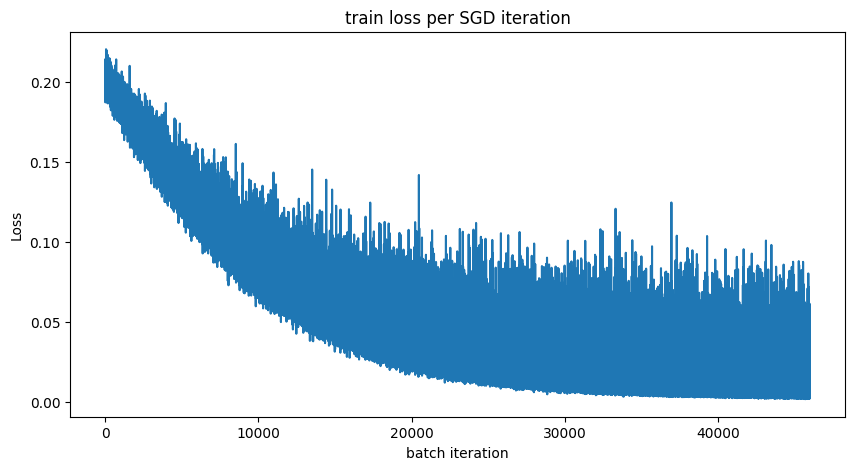

In [55]:

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))  
plt.plot(training_losses_all)  

plt.title('train loss per SGD iteration')
plt.xlabel('batch iteration')
plt.ylabel('Loss')

plt.show()




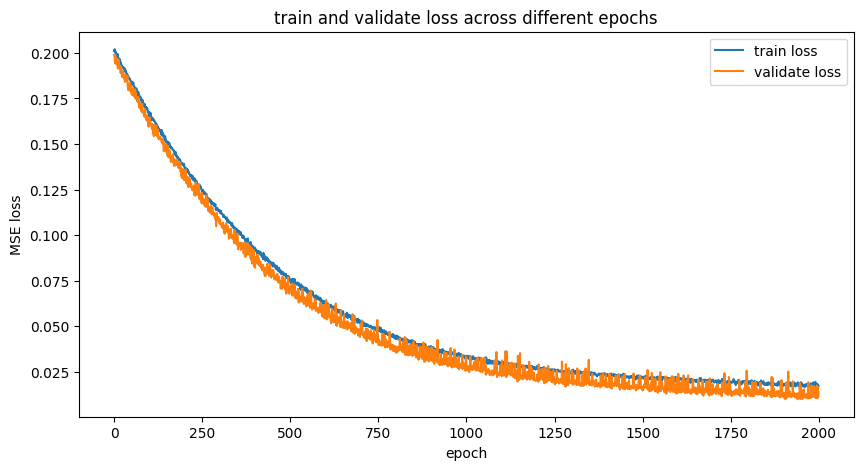

In [56]:
plt.figure(figsize=(10, 5))  
plt.plot(training_losses)  
plt.plot(validate_losses)
plt.title('train and validate loss across different epochs')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend(['train loss', 'validate loss'], loc='upper right')
plt.show()

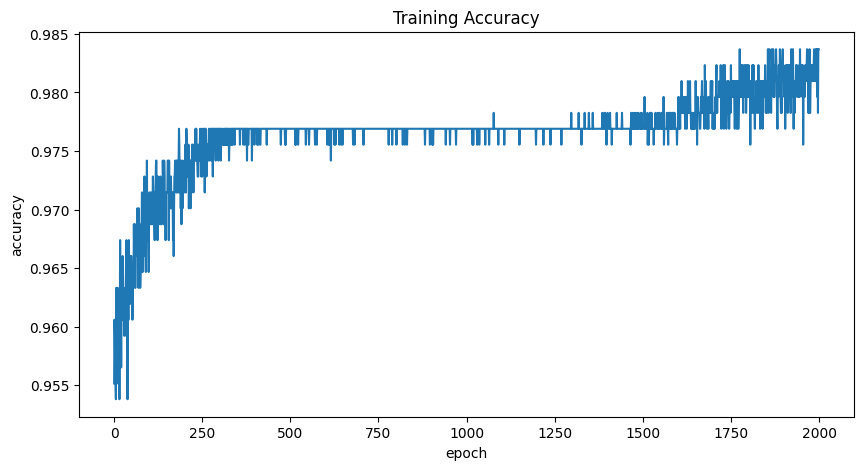

In [57]:
# plot the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list)
plt.title('Training Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [58]:
## calculate baseline accuracy
total = c2_data.count()
attack = c2_data.filter(col("outcome")==1).count()
normal = c2_data.filter(col("outcome")==0).count()

base_acc = normal/total
print("Baseline accuracy: ", base_acc)

Baseline accuracy:  0.9791666666666666


In [59]:
## calculate train accuracy
pred = mymodel(x_train)
pred = pred.detach().numpy()
pred = np.round(pred)
train_acc = np.mean(pred == y_train.numpy())
print("Train accuracy: ", train_acc)

Train accuracy:  0.9809782608695652


In [60]:
## calculate test accuracy
test_pred = mymodel(x_test)
test_pred = test_pred.detach().numpy()
test_pred = test_pred > 0.5
test_pred = test_pred.astype(int)

test_acc = np.sum(test_pred == y_test.numpy())/len(y_test)
print("Test accuracy: ", test_acc)

Test accuracy:  0.9948717948717949


In [61]:
## calculate TP, TN, FP, FN and F1 score and AUC and ROC and PR curve for the test set and plot all of them
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

conf_matrix = confusion_matrix(y_test, test_pred)
print("Confusion Matrix: ")
print(conf_matrix)

f1 = f1_score(y_test, test_pred)
print("F1 Score: ", f1)

Confusion Matrix: 
[[192   0]
 [  1   2]]
F1 Score:  0.8
